In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time


In [ ]:
sns.set_style('whitegrid')

# ✅ Indian IT companies (NSE)
tickers = ['TCS.NS', 'INFY.NS', 'WIPRO.NS', 'TECHM.NS']
weights = np.array([0.25, 0.25, 0.25, 0.25])  # equal weight

start = dt.datetime(2020, 1, 1)
end = dt.datetime.today()

# Container for adjusted close prices
prices = pd.DataFrame()

# Fetch prices
for ticker in tickers:
    print(f'Fetching {ticker} - ', end="")
    try:
        df = yf.Ticker(ticker).history(
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            auto_adjust=True,
        )
        series = df['Close']
        print("Finance", end="")
    except Exception as e:
        print(f' X Finance error {e}; falling back to stooq', end="")
        df2 = pdr.DataReader(ticker, 'stooq', start, end)
        df2 = df2.sort_index()
        series = df2['Close']

    prices[ticker] = series
    time.sleep(1)
    print()

# Clean the final DataFrame
prices = prices.dropna(how='all').ffill().bfill()

print(prices.head())
print(prices.tail())


Fetching TCS.NS - Finance
Fetching INFY.NS - Finance
Fetching WIPRO.NS - Finance
Fetching TECHM.NS - Finance
                                TCS.NS     INFY.NS    WIPRO.NS    TECHM.NS
Date                                                                      
2020-01-01 00:00:00+05:30  1986.125366  646.518799  116.644875  655.898560
2020-01-02 00:00:00+05:30  1977.007935  644.632385  116.927422  659.298279
2020-01-03 00:00:00+05:30  2016.408447  654.547180  118.245979  667.086975
2020-01-06 00:00:00+05:30  2016.225220  648.273621  118.740425  663.042053
2020-01-07 00:00:00+05:30  2021.172607  638.665955  120.176712  668.808289
                                TCS.NS      INFY.NS    WIPRO.NS     TECHM.NS
Date                                                                        
2025-08-20 00:00:00+05:30  3098.600098  1496.199951  250.839996  1524.099976
2025-08-21 00:00:00+05:30  3102.600098  1496.400024  249.910004  1521.300049
2025-08-22 00:00:00+05:30  3054.000000  1487.500000  248.6

In [ ]:
#log -return = In(P_t/P_{t-1})
logR=np.log(prices/prices.shift(1)).dropna()
logR.head()


,TCS.NS,INFY.NS,WIPRO.NS,TECHM.NS
Date,,,,
2020-01-02 00:00:00+05:30,-0.004601,-0.002922,0.002419,0.005170
2020-01-03 00:00:00+05:30,0.019733,0.015263,0.011214,0.011744
2020-01-06 00:00:00+05:30,-0.000091,-0.009631,0.004173,-0.006082
2020-01-07 00:00:00+05:30,0.002451,-0.014931,0.012023,0.008659
2020-01-08 00:00:00+05:30,0.022148,-0.013416,-0.001569,-0.009438


In [ ]:
logR.shape

(1400, 4)

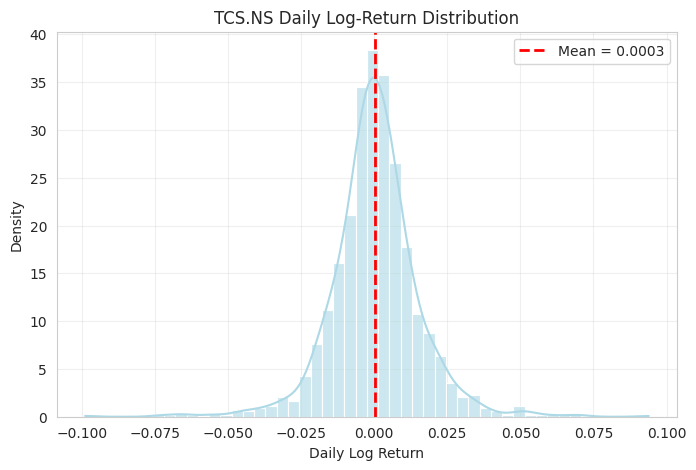

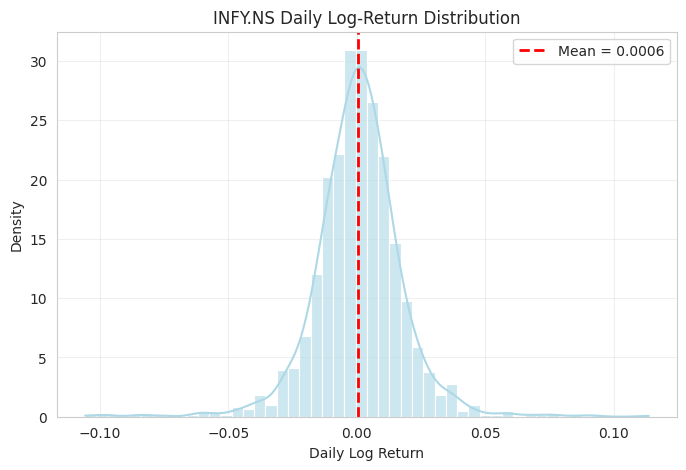

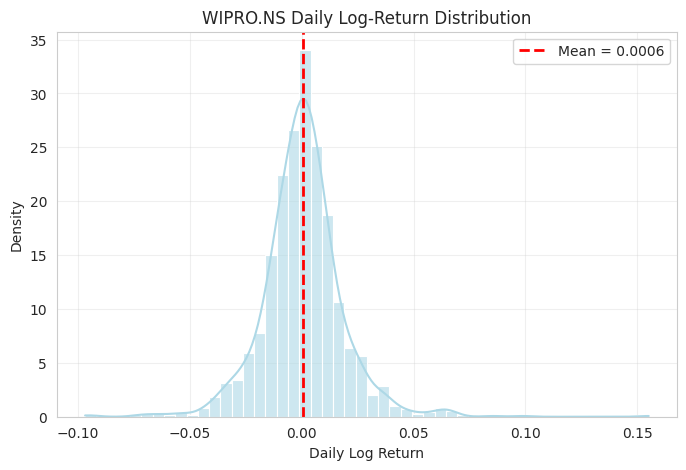

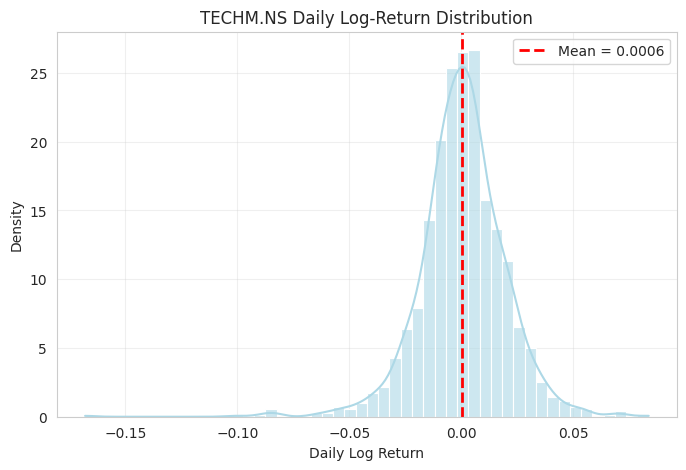

In [ ]:


# Plot histograms for all stocks in logR
for ticker in logR.columns:
    data = logR[ticker].dropna()   # drop NaNs to avoid errors

    # Mean
    mean_val = data.mean()

    plt.figure(figsize=(8,5))

    # Histogram + KDE
    sns.histplot(data, bins=50, kde=True, stat="density", color="lightblue", alpha=0.6)

    # Add mean line
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.4f}")

    # Titles and labels
    plt.title(f"{ticker} Daily Log-Return Distribution")
    plt.xlabel("Daily Log Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:


# Compute extended summary statistics
summary = pd.DataFrame({
    'Mean': logR.mean(),
    'Skewness': logR.skew(),               # Positive = right skew
    'Kurtosis': logR.kurtosis(),
    'Std_Dev': logR.std(),                 # Standard deviation for risk
    'Variance': logR.var(),
    'Min': logR.min(),                      # Minimum daily log return
    'Max': logR.max(),                      # Maximum daily log return
    'Range': logR.max() - logR.min()     # Range of returns
   # >3 = fat tails
})

# Round for readability
summary = summary.round(6)

# Sort by Mean descending (highest average return first)
summary = summary.sort_values(by='Mean', ascending=False)
summary


,Mean,Skewness,Kurtosis,Std_Dev,Variance,Min,Max,Range
INFY.NS,0.000615,-0.130357,6.289119,0.017439,0.000304,-0.105797,0.113627,0.219424
TECHM.NS,0.000592,-0.746281,6.280162,0.019381,0.000376,-0.168040,0.083838,0.251878
WIPRO.NS,0.000550,0.520995,6.818611,0.018249,0.000333,-0.096783,0.155103,0.251886
TCS.NS,0.000331,-0.061263,5.148599,0.015178,0.000230,-0.098830,0.093901,0.192731


In [ ]:
# 4.1 fit Normal : mean µ ,std σ
mu_norm ,sigma_norm = logR.stack().mean(),logR.stack().std(ddof=1)
print("mu_norm" ,mu_norm,"sigma_norm", sigma_norm)
# 95% CI for mean under Normal : µ ± z*-σ/√N
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm =(mu_norm - z95*sigma_norm/np.sqrt(N),
             mu_norm + z95*sigma_norm/ np.sqrt(N))

# 95% CI for σ via Chi -square :
df = N-1
chi2_low ,chi2_high =stats.chi2.ppf([0.025, 0.975],df)
ci_sigma_norm =(sigma_norm*np.sqrt(df/chi2_high),
                sigma_norm*np.sqrt(df/chi2_low),)
print("Normal fit: ")
print(f" µ= { mu_norm:.5f}, 95% CI { ci_mu_norm}  ")
print(f" σ= { sigma_norm:.5f}, 95% CI { ci_sigma_norm}  ")

mu_norm 0.0005220987454012475 sigma_norm 0.017624713451135157
Normal fit: 
 µ= 0.00052, 95% CI (np.float64(6.048775284792833e-05), np.float64(0.0009837097379545665))  
 σ= 0.01762, 95% CI (np.float64(0.017304261342451686), np.float64(0.01795734434173799))  


In [ ]:



# Create an empty DataFrame to store results
summary_individual = pd.DataFrame(columns=['Mean', '95% CI Mean', 'Std Dev', '95% CI Std Dev'])

for ticker in logR.columns:
    data = logR[ticker].dropna()
    N = data.size

    # Fit Normal: mean µ, std σ
    mu = data.mean()
    sigma = data.std(ddof=1)

    # 95% CI for mean: µ ± z*σ/√N
    z95 = stats.norm.ppf(0.975)
    ci_mu = (mu - z95 * sigma / np.sqrt(N), mu + z95 * sigma / np.sqrt(N))

    # 95% CI for σ via Chi-square
    df = N - 1
    chi2_low, chi2_high = stats.chi2.ppf([0.025, 0.975], df)
    ci_sigma = (sigma * np.sqrt(df / chi2_high), sigma * np.sqrt(df / chi2_low))

    # Store results
    summary_individual.loc[ticker] = [mu, ci_mu, sigma, ci_sigma]

# Optional: round numbers for readability
summary_individual = summary_individual.round(6)

# Display results
print(summary_individual)


              Mean                                       95% CI Mean  \
TCS.NS    0.000331  (-0.00046396841134353355, 0.0011261110610227543)   
INFY.NS   0.000615   (-0.0002983844024365814, 0.0015286119034363518)   
WIPRO.NS  0.000550  (-0.00040563348220258317, 0.0015062250025022084)   
TECHM.NS  0.000592    (-0.000423307890190157, 0.0016071361824215207)   

           Std Dev                                95% CI Std Dev  
TCS.NS    0.015178   (0.014635565144356424, 0.01576175927250507)  
INFY.NS   0.017439  (0.016816218256883623, 0.018110211763234227)  
WIPRO.NS  0.018249   (0.017597315031082833, 0.01895141326123074)  
TECHM.NS  0.019381     (0.0186888121085278, 0.02012690009837309)  


In [24]:
# Flatten all log returns into one array
returns_flat = logR.stack().values
N = len(returns_flat)

#  Fit Student's t-distribution to the pooled returns
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

# Bootstrap to estimate 95% confidence intervals for μ and σ
B = 1000  # number of bootstrap samples
estimates = np.array([
    stats.t.fit(np.random.choice(returns_flat, size=N, replace=True))
    for _ in range(B)
])

# Confidence intervals from percentiles
ci_mu_t = np.percentile(estimates[:,1], [2.5, 97.5])
ci_sigma_t = np.percentile(estimates[:,2], [2.5, 97.5])

# 3️ Display results
print("\nStudent's t-distribution fit:")
print(f"Degrees of freedom (df) = {df_t:.2f}")
print(f"Mean (µ) = {mu_t:.5f}, 95% CI: {ci_mu_t}")
print(f"Std (σ) = {sigma_t:.5f}, 95% CI: {ci_sigma_t}")



Student's t-distribution fit:
Degrees of freedom (df) = 3.46
Mean (µ) = 0.00049, 95% CI: [0.00011481 0.00084567]
Std (σ) = 0.01186, 95% CI: [0.01145329 0.01227698]


In [25]:

from scipy.stats import norm

# Step 1: Portfolio daily returns
portR = logR.dot(weights)

# Step 2: Portfolio mean and volatility
mu_portfolio = portR.mean()             # expected daily return
sigma_portfolio = portR.std(ddof=1)     # daily volatility

# Step 3: 1-day 95% VaR (Normal Distribution)
z_05 = norm.ppf(0.05)                   # z-score for 5% left tail (-1.645)
VaR_95_normal = -(mu_portfolio + z_05 * sigma_portfolio)

# Step 4: Results
print("Portfolio Risk and 1-Day 95% VaR (Normal Distribution):")
print(f"Average daily return (μ)  : {mu_portfolio:.5f}")
print(f"Portfolio volatility (σ)   : {sigma_portfolio:.5f}")
print(f"1-Day 95% VaR              : {VaR_95_normal:.5f}")


Portfolio Risk and 1-Day 95% VaR (Normal Distribution):
Average daily return (μ)  : 0.00052
Portfolio volatility (σ)   : 0.01497
1-Day 95% VaR              : 0.02410


In [26]:


# Suppose logR is your DataFrame of daily log returns for each stock
# Example: columns = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS"]

# Step 1: Calculate mean and volatility for each stock
mu_individual = logR.mean()              # average daily return for each stock
sigma_individual = logR.std(ddof=1)      # daily volatility for each stock

# Step 2: z-score for 95% confidence
z_05 = norm.ppf(0.05)   # -1.645

# Step 3: Calculate 1-day 95% VaR for each stock
VaR_individual = -(mu_individual + z_05 * sigma_individual)

# Step 4: Results
print("Individual Stock Risk and 1-Day 95% VaR (Normal Distribution):\n")
for stock in logR.columns:
    print(f"{stock}:")
    print(f"  Avg daily return (μ) : {mu_individual[stock]:.5f}")
    print(f"  Volatility (σ)       : {sigma_individual[stock]:.5f}")
    print(f"  1-Day 95% VaR        : {VaR_individual[stock]:.5f}\n")


Individual Stock Risk and 1-Day 95% VaR (Normal Distribution):

TCS.NS:
  Avg daily return (μ) : 0.00033
  Volatility (σ)       : 0.01518
  1-Day 95% VaR        : 0.02463

INFY.NS:
  Avg daily return (μ) : 0.00062
  Volatility (σ)       : 0.01744
  1-Day 95% VaR        : 0.02807

WIPRO.NS:
  Avg daily return (μ) : 0.00055
  Volatility (σ)       : 0.01825
  1-Day 95% VaR        : 0.02947

TECHM.NS:
  Avg daily return (μ) : 0.00059
  Volatility (σ)       : 0.01938
  1-Day 95% VaR        : 0.03129



In [27]:
# Step 1: Portfolio daily returns
portR = logR.dot(weights)

# Step 2: Fit Student's t-distribution to portfolio returns
# Get parameters: df (degrees of freedom), loc (mean), scale (std dev)
df, loc, scale = stats.t.fit(portR)

# Step 3: Calculate 95% left-tail cutoff for Student's t
alpha = 0.05
t_crit = stats.t.ppf(alpha, df)

# Step 4: Calculate 1-day 95% VaR
VaR_t = -(loc + scale * t_crit)

print("average Portfolio Risk and 1-Day 95% VaR (Student’s t-Distribution):")
print(f"Average daily return (μ)  : {loc:.5f}")
print(f"Portfolio volatility (σ)   : {scale:.5f}")
print(f"Degrees of freedom (df)    : {df:.2f}")
print(f"1-Day 95% VaR (t-dist)     : {VaR_t:.5f}")

average Portfolio Risk and 1-Day 95% VaR (Student’s t-Distribution):
Average daily return (μ)  : 0.00066
Portfolio volatility (σ)   : 0.01027
Degrees of freedom (df)    : 3.59
1-Day 95% VaR (t-dist)     : 0.02197


In [29]:
alpha = 0.05  # 95% VaR

# Create a dictionary to store results
VaR_individual = {}

for stock in logR.columns:
    # Fit Student's t-distribution to the stock returns
    df, loc, scale = stats.t.fit(logR[stock])

    # 5% left-tail critical value
    t_crit = stats.t.ppf(alpha, df)

    # 1-day 95% VaR
    VaR = -(loc + scale * t_crit)

    VaR_individual[stock] = {
        "Average daily return (μ)": loc,
        "Volatility (σ)": scale,
        "Degrees of freedom (df)": df,
        "1-Day 95% VaR": VaR
    }

# Convert to DataFrame for better visualization
VaR_individual_df = pd.DataFrame(VaR_individual).T
print(VaR_individual_df)

          Average daily return (μ)  Volatility (σ)  Degrees of freedom (df)  \
TCS.NS                    0.000214        0.009959                 3.238037   
INFY.NS                   0.000691        0.011676                 3.521959   
WIPRO.NS                  0.000272        0.011898                 3.213538   
TECHM.NS                  0.000862        0.014255                 4.349502   

          1-Day 95% VaR  
TCS.NS         0.022538  
INFY.NS        0.025205  
WIPRO.NS       0.026986  
TECHM.NS       0.028840  


In [28]:
# Step 1: Calculate portfolio daily returns
portR = logR.dot(weights)

# Step 2: Calculate Historical 1-day 95% VaR for the portfolio
VaR_hist_portfolio = -np.percentile(portR, 5)  # 5th percentile, expressed as positive number
# Display results
print(f"Historical 1-Day 95% VaR: {historical_VaR_95:.5f} ({historical_VaR_95*100:.2f}% potential loss)")

# Step 3: Historical 1-day 95% VaR for each individual stock
VaR_hist_individual = {}
for stock in logR.columns:
    VaR_hist_individual[stock] = -np.percentile(logR[stock], 5)

# Convert to DataFrame for display
VaR_hist_individual_df = pd.DataFrame.from_dict(VaR_hist_individual, orient='index', columns=['1-Day 95% Historical VaR'])
print(VaR_hist_individual_df)


# 5th percentile return (worst 5% threshold)
percentile_5 = np.percentile(portR, 5)
print(f"5th percentile return (worst 5% threshold): {percentile_5:.5f}")

# Express as positive VaR (potential loss)
VaR_hist = -percentile_5
print(f"Historical 1-Day 95% VaR: {VaR_hist:.5f}")


Historical 1-Day 95% VaR: 0.02219 (2.22% potential loss)
          1-Day 95% Historical VaR
TCS.NS                    0.021629
INFY.NS                   0.025541
WIPRO.NS                  0.027512
TECHM.NS                  0.028357
5th percentile return (worst 5% threshold): -0.02219
Historical 1-Day 95% VaR: 0.02219


In [31]:

from scipy.stats import norm, t

returns = prices.pct_change().dropna()
portR = returns.dot(weights)

mu_t = portR.mean()
sigma_t = portR.std()

# Normal VaR
z_05 = norm.ppf(0.05)
VaR_norm = -(mu_t + sigma_t * z_05)

# Student's t VaR
t_05 = t.ppf(0.05, df)
VaR_t = -(mu_t + sigma_t * t_05)

# Historical VaR
hist_var = -np.percentile(portR, 5)

print("1-Day 95% VaR:")
print(f"  Parametric (Normal):         {VaR_norm:.5f}")
print(f"  Parametric (Student’s t):    {VaR_t:.5f}")
print(f"  Historical (5th percentile): {hist_var:.5f}")


1-Day 95% VaR:
  Parametric (Normal):         0.02392
  Parametric (Student’s t):    0.03048
  Historical (5th percentile): 0.02188


In [32]:
#historical VaR (non -parametric):
hist_var = np.percentile(portR ,5)

print("1-Day 95% VaR: ")
print(f"Parametric (Normal) : {VaR_norm:.5f}")
print(f"Parametric (student's t) : {VaR_t:.5f}")
print(f"Historical VaR = {hist_var:.5f}")



1-Day 95% VaR: 
Parametric (Normal) : 0.02392
Parametric (student's t) : 0.03048
Historical VaR = -0.02188


In [33]:
from scipy.stats import norm, t, ttest_1samp


# t-test for mean
t_stat, p_val = ttest_1samp(portR.dropna(), 0.0)
print(f"\n one sample day T-test for Portfolio daily Return:")
print(f"t-stat = {t_stat:.3f}, p-value = {p_val:.3f}")
if p_val < 0.05:
    print("→ Reject null hypothesis (mean return ≠ 0)")
else:
    print("→ Fail to reject null hypothesis (mean return not significantly different from 0)")



 one sample day T-test for Portfolio daily Return:
t-stat = 1.695, p-value = 0.090
→ Fail to reject null hypothesis (mean return not significantly different from 0)


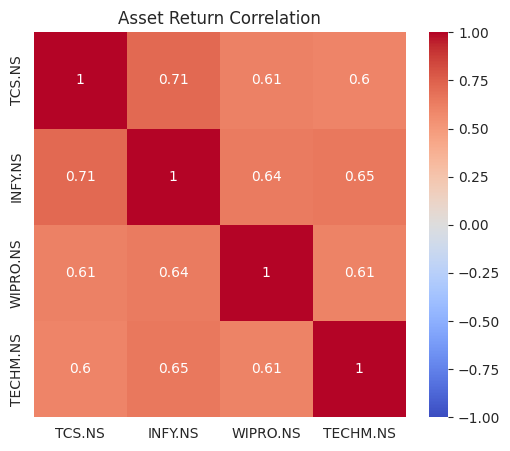

Individual volatilities:
TCS.NS      0.015178
INFY.NS     0.017439
WIPRO.NS    0.018249
TECHM.NS    0.019381
dtype: float64

Naive weighted volatility (σ_weighted) = 0.0176
Portfolio volatility (σ_portfolio)       = 0.0150
Diversification benefit                  = 0.0026
Historical 95% VaR                       = 0.0222

Bottom 5% returns (worst days):
[-0.09984622 -0.08415756 -0.08412965 -0.06672096 -0.06017861 -0.0580176
 -0.05234893 -0.05126346 -0.04953268 -0.04928746 -0.04777367 -0.04684682
 -0.04673369 -0.04138707 -0.04125916 -0.03951649 -0.03807853 -0.03771887
 -0.03768596 -0.0367178  -0.03552965 -0.03463438 -0.03434187 -0.03360973
 -0.03244839 -0.03225909 -0.03197508 -0.03140385 -0.03118814 -0.03111929
 -0.03103506 -0.03085575 -0.03029006 -0.03025871 -0.03019598 -0.02998593
 -0.0297717  -0.02953768 -0.02939111 -0.02918254 -0.02896464 -0.02888592
 -0.02885825 -0.02821648 -0.02816662 -0.02758082 -0.02757557 -0.02736761
 -0.02701547 -0.02697924 -0.02644693 -0.02634079 -0.02614364 

In [34]:
corr = logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Asset Return Correlation")
plt.show()


# Individual volatilities

σ_i = logR.std()  # daily std dev of each stock
print("Individual volatilities:")
print(σ_i)

 #Naive weighted average of volatilities
σ_weighted = np.dot(weights, σ_i)
print(f"\nNaive weighted volatility (σ_weighted) = {σ_weighted:.4f}")

cov_matrix = logR.cov()
σ_portfolio = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
print(f"Portfolio volatility (σ_portfolio)       = {σ_portfolio:.4f}")

# Diversification benefit
print(f"Diversification benefit                  = {σ_weighted - σ_portfolio:.4f}")
# Historical 95% VaR

# Compute portfolio daily returns
port_returns = logR.dot(weights)

# Historical 95% VaR (5th percentile)
VaR_95 = -np.percentile(port_returns, 5)  # negative for reporting as positive loss
print(f"Historical 95% VaR                       = {VaR_95:.4f}")

# Optional: view sorted portfolio returns

sorted_returns = np.sort(port_returns)  # ascending order (worst to best)
print("\nBottom 5% returns (worst days):")
print(sorted_returns[:int(0.05*len(sorted_returns))])

Max Drawdown: -39.30%
From: 2022-01-04 00:00:00+05:30 to 2023-04-19 00:00:00+05:30


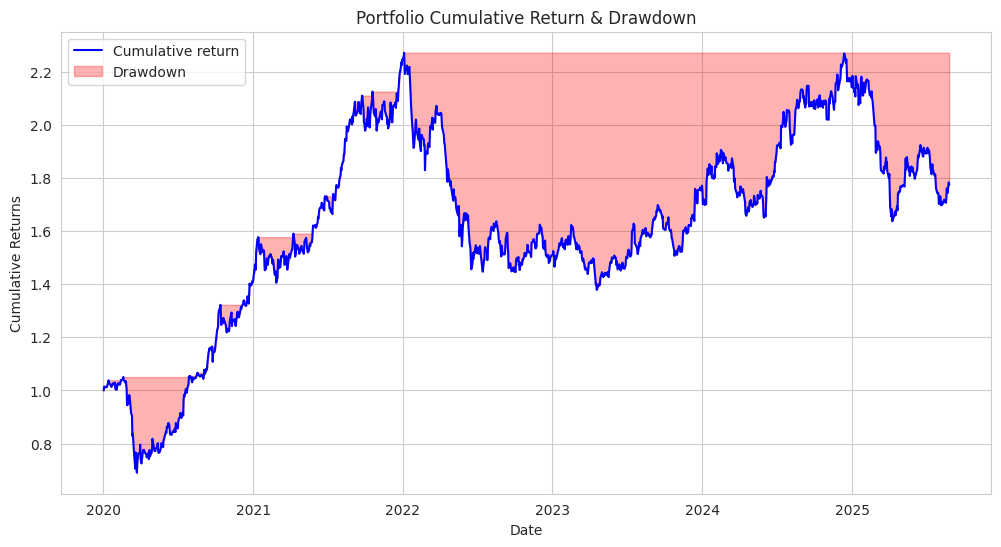

In [35]:


# Step 1: Cumulative return
cumulative_returns = (1 + port_returns).cumprod()

# Step 2: Running maximum
running_max = cumulative_returns.cummax()

# Step 3: Drawdown
drawdown = (cumulative_returns - running_max) / running_max

# Step 4: Max Drawdown info
max_drawdown = drawdown.min()
end_date = drawdown.idxmin()
start_date = cumulative_returns[:end_date].idxmax()

print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"From: {start_date} to {end_date}")

# Step 5: Single Graph with shaded drawdown
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label="Cumulative return", color="blue")
plt.fill_between(cumulative_returns.index, cumulative_returns, running_max, color="red", alpha=0.3, label="Drawdown")
plt.title("Portfolio Cumulative Return & Drawdown")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()



--- TCS.NS ---
Max Drawdown: -32.92%
From: 2024-08-30 to 2025-08-01


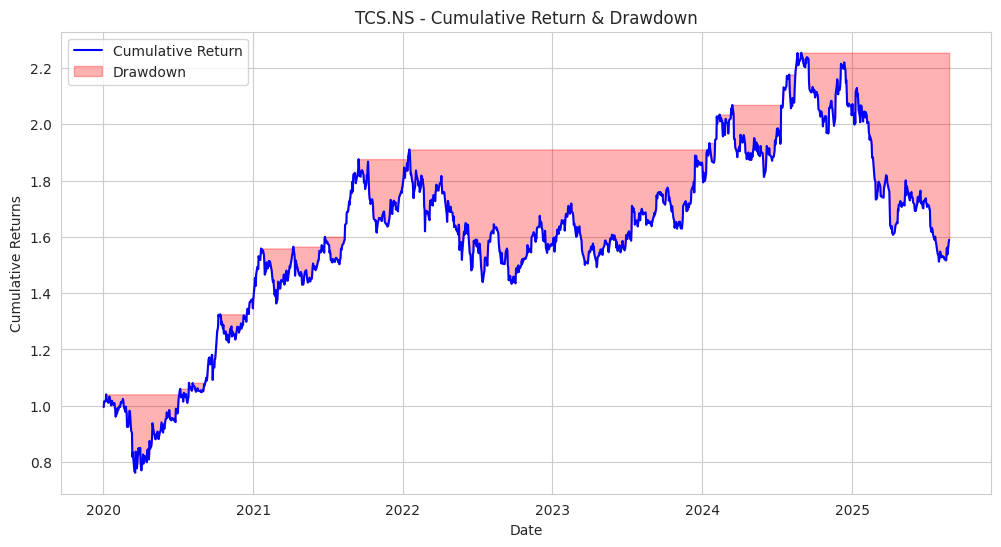


--- INFY.NS ---
Max Drawdown: -35.56%
From: 2022-01-17 to 2023-04-20


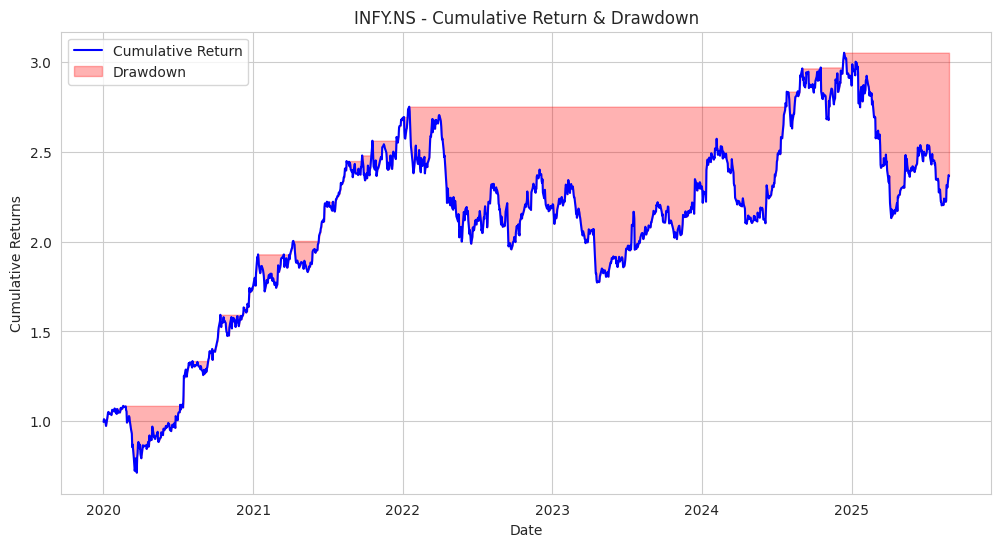


--- WIPRO.NS ---
Max Drawdown: -50.02%
From: 2022-01-04 to 2023-03-28


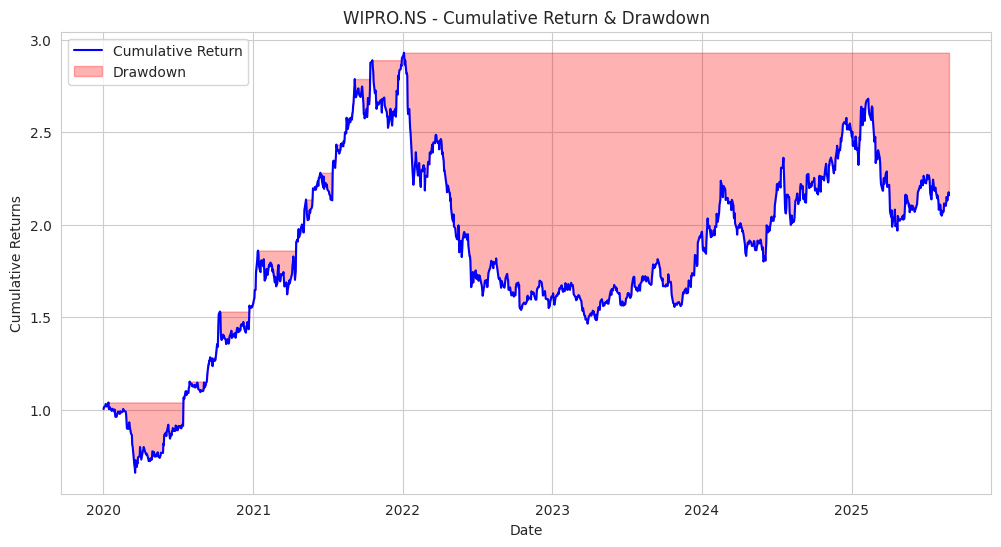


--- TECHM.NS ---
Max Drawdown: -46.57%
From: 2021-12-28 to 2022-06-17


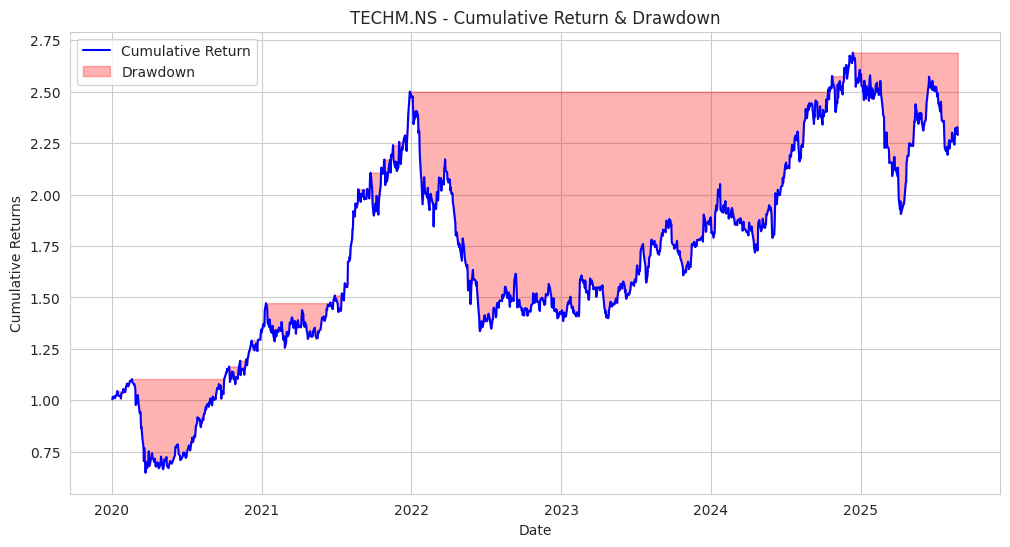

In [36]:
stock_returns = prices.pct_change().dropna()
for ticker in stock_returns.columns:
    cumulative_returns = (1 + stock_returns[ticker]).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    start_date = cumulative_returns[:end_date].idxmax()

    print(f"\n--- {ticker} ---")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"From: {start_date.date()} to {end_date.date()}")

    plt.figure(figsize=(12,6))
    plt.plot(cumulative_returns, label="Cumulative Return", color="blue")
    plt.fill_between(cumulative_returns.index, cumulative_returns, running_max,
                     color="red", alpha=0.3, label="Drawdown")
    plt.title(f"{ticker} - Cumulative Return & Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()


In [37]:
confidence_level = 0.95   # 95% confidence → worst 5% of days
alpha = 1 - confidence_level  # 0.05

# Step 2: Historical Expected Shortfall
VaR_hist = port_returns.quantile(alpha)   # Historical VaR at 95%
ES_hist = port_returns[port_returns <= VaR_hist].mean()  # Historical Expected Shortfall

# Step 3: Parametric Expected Shortfall (Normal Distribution)
mu = port_returns.mean()       # Average daily return
sigma = port_returns.std()     # Std dev of daily returns

# Parametric VaR under normal distribution
VaR_param = norm.ppf(alpha, mu, sigma)

# Parametric Expected Shortfall (formula for CVaR under normal distribution)
ES_param = mu - (sigma * norm.pdf(norm.ppf(alpha)) / alpha)

# Step 4: Compare Results
print("---- Expected Shortfall (95% Confidence) ----")
print(f"Historical VaR (5% worst cutoff): {VaR_hist:.4f}")
print(f"Historical ES (avg of worst 5%): {ES_hist:.4f}")
print(f"Parametric VaR (Normal): {VaR_param:.4f}")
print(f"Parametric ES (Normal): {ES_param:.4f}")


---- Expected Shortfall (95% Confidence) ----
Historical VaR (5% worst cutoff): -0.0222
Historical ES (avg of worst 5%): -0.0353
Parametric VaR (Normal): -0.0241
Parametric ES (Normal): -0.0304


In [38]:
confidence_level = 0.95
alpha = 1 - confidence_level  # 0.05

# Step 1: Historical VaR at 95%
VaR_hist = port_returns.quantile(alpha)

# Step 2: Count exceptions (days when actual return < VaR)
exceptions = port_returns[port_returns < VaR_hist]
num_exceptions = len(exceptions)
total_days = len(port_returns)

# Step 3: Exception rate
exception_rate = num_exceptions / total_days

# Step 4: Print results
print("---- Backtesting VaR (95% Confidence) ----")
print(f"Historical VaR (5% cutoff): {VaR_hist:.4f}")
print(f"Total days: {total_days}")
print(f"Exceptions (days below VaR): {num_exceptions}")
print(f"Exception Rate: {exception_rate*100:.2f}%")

# Step 5: Compare with expected 5%
if abs(exception_rate - 0.05) < 0.01:
    print(" Model is well calibrated (close to 5%).")
elif exception_rate > 0.05:
    print(" Model is underestimating risk (too many exceptions).")
else:
    print("ℹ Model is conservative (too few exceptions).")

---- Backtesting VaR (95% Confidence) ----
Historical VaR (5% cutoff): -0.0222
Total days: 1400
Exceptions (days below VaR): 70
Exception Rate: 5.00%
 Model is well calibrated (close to 5%).


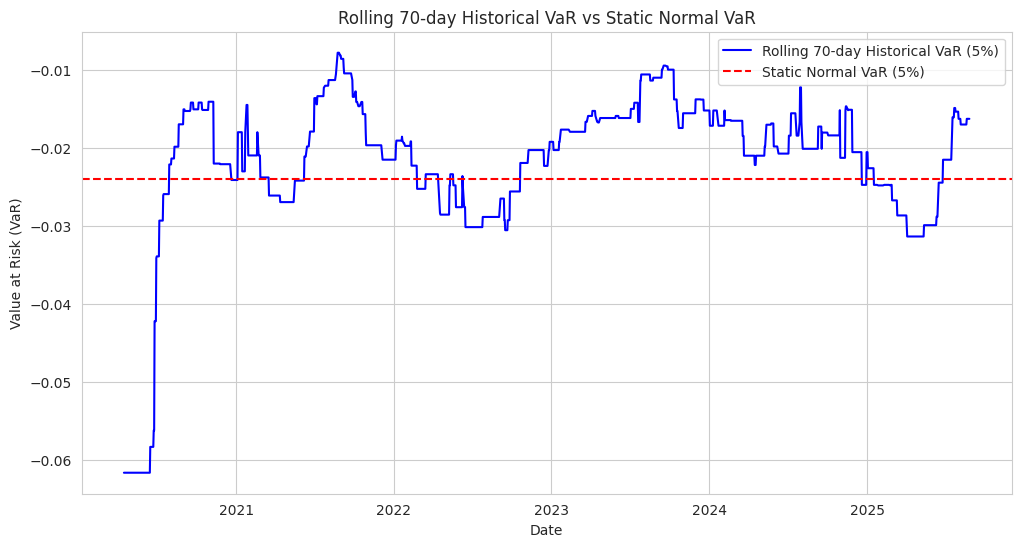

In [39]:

from scipy.stats import norm

# If portR is already a Series of returns:
returns = portR.dropna()

# Confidence level (95%)
alpha = 0.05

# ---- Static (Normal-based) VaR ----
mu = returns.mean()
sigma = returns.std()
z_alpha = norm.ppf(alpha)
static_var = mu + sigma * z_alpha   # fixed line

# ---- Rolling Historical VaR ----
window = 70
rolling_var = returns.rolling(window).quantile(alpha)

# ---- Plot Results ----
plt.figure(figsize=(12,6))
plt.plot(returns.index, rolling_var, label=f"Rolling {window}-day Historical VaR (5%)", color="blue")
plt.axhline(static_var, color="red", linestyle="--", label="Static Normal VaR (5%)")
plt.title(f"Rolling {window}-day Historical VaR vs Static Normal VaR")
plt.xlabel("Date")
plt.ylabel("Value at Risk (VaR)")
plt.legend()
plt.grid(True)
plt.show()


Total exceptions over sample: 74
Exception rate: 5.29%


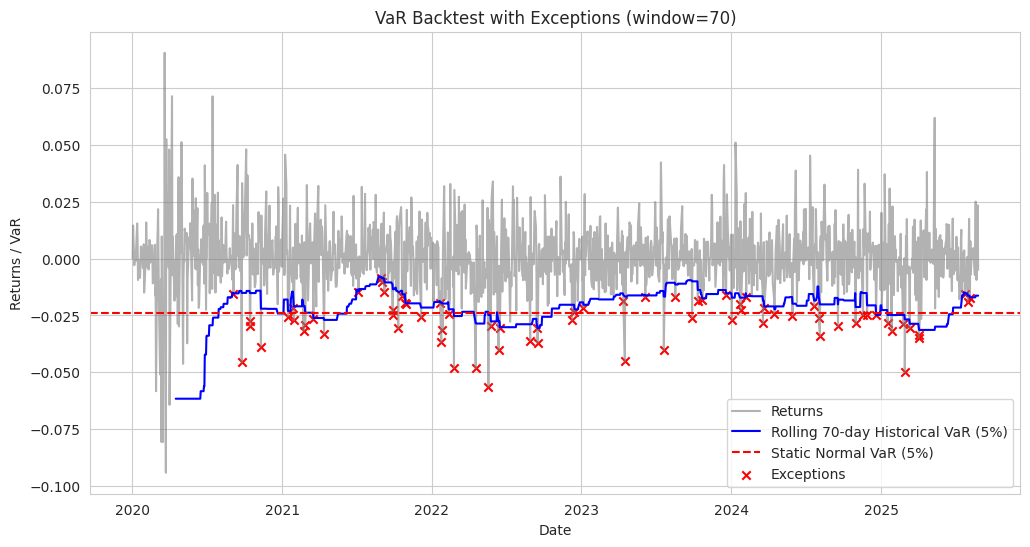

In [40]:
# Compare returns with rolling VaR
exceptions = returns < rolling_var

# Count total exceptions
num_exceptions = exceptions.sum()

print(f"Total exceptions over sample: {num_exceptions}")
print(f"Exception rate: {num_exceptions / len(returns):.2%}")

# Plot exceptions on chart
plt.figure(figsize=(12,6))
plt.plot(returns.index, returns, color="grey", alpha=0.6, label="Returns")
plt.plot(rolling_var, color="blue", label=f"Rolling {window}-day Historical VaR (5%)")
plt.axhline(static_var, color="red", linestyle="--", label="Static Normal VaR (5%)")
plt.scatter(returns.index[exceptions], returns[exceptions], color="red", marker="x", label="Exceptions")
plt.title(f"VaR Backtest with Exceptions (window={window})")
plt.xlabel("Date")
plt.ylabel("Returns / VaR")
plt.legend()
plt.grid(True)
plt.show()



Jarque-Bera Test Results
-------------------------
Sample Size (n): 1400
Mean           : 0.000678
Std Dev        : 0.014953
Skewness       : -0.159807
Kurtosis       : 7.905071  (Normal = 3)
JB Statistic   : 1396.9920
p-value        : 4.437e-304

❌ Reject Normality: Returns do NOT follow a normal distribution.


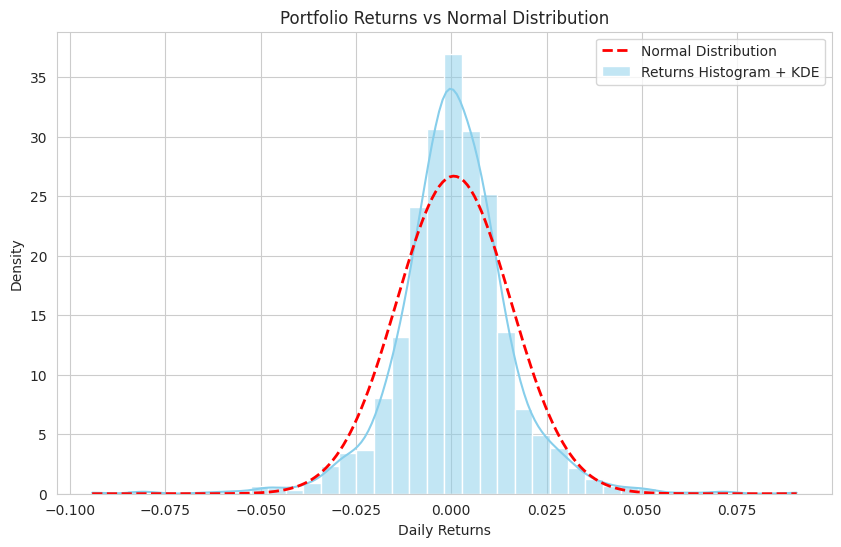

In [41]:
from scipy.stats import jarque_bera, skew, kurtosis, norm

# ---- Step 0: Clean returns ----
returns = portR.dropna().astype(float)

# ---- Step 1: Run Jarque-Bera Test ----
jb_stat, p_value = jarque_bera(returns)

# Extra stats
S = skew(returns, bias=False)
K = kurtosis(returns, fisher=False, bias=False)  # normal = 3

print("Jarque-Bera Test Results")
print("-------------------------")
print(f"Sample Size (n): {len(returns)}")
print(f"Mean           : {returns.mean():.6f}")
print(f"Std Dev        : {returns.std():.6f}")
print(f"Skewness       : {S:.6f}")
print(f"Kurtosis       : {K:.6f}  (Normal = 3)")
print(f"JB Statistic   : {jb_stat:.4f}")
print(f"p-value        : {p_value:.3e}")   # scientific notation

# ---- Step 2: Decision ----
alpha = 0.05
if p_value < alpha:
    print("\n❌ Reject Normality: Returns do NOT follow a normal distribution.")
else:
    print("\n✅ Cannot Reject Normality: Returns MIGHT follow a normal distribution.")

# ---- Step 3: Plot Histogram + KDE + Normal Curve ----
mu, sigma = returns.mean(), returns.std()

plt.figure(figsize=(10,6))
sns.histplot(returns, bins=40, kde=True, stat="density", color="skyblue", label="Returns Histogram + KDE")

# Normal distribution curve
x = np.linspace(returns.min(), returns.max(), 200)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=2, label="Normal Distribution")

plt.title("Portfolio Returns vs Normal Distribution")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
